# Mehrdad Baradaran 


# Neuran Population

# STD_id = 99222020

# Implementations :

In [6]:
#Import Necessary Libraries
from matplotlib.pyplot import *
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from statistics import mode

# Leaky Integrate and Fire Neuron Model

# Implementing LIF Model

In [7]:
class LIF:
    def __init__(self, i_func, time_interval=100, dt=0.125, u_rest=0, R=1, 
                 C=10, threshold=5, neuron_type='excitatory'):
        self.time_interval = time_interval
        self.dt = dt
        self.i_func = i_func
        self.u_rest = u_rest
        self.R = R
        self.C = C
        self.threshold = threshold
        self.u = []
        self.i_init = []
        self.timer = []
        self.cur_time = 0
        self.is_spiked = False
        self.type = neuron_type
        
     #init u values
    def start(self):
        self.timer = np.arange(0, self.time_interval + self.dt, self.dt)
        u = [self.u_rest for i in range(len(self.timer))]
        self.i_init = [self.i_func(j) for j in self.timer]
        
        const = self.R * self.C
        for t in range(len(self.timer)):
            self.is_spiked = False
            self.cur_time = t
            u[t] = u[t-1] + (((-u[t-1] + self.u_rest) + self.R * self.i_init[t]) * self.dt)/const
            self.u = u
            #checking for action potential
            if u[t] >= self.threshold or u[t] < self.u_rest:
                u[t] = self.u_rest
                self.is_spiked = True
                self.u = u
            yield self.is_spiked
            
        
        
     #draw desire plot (u-t/i-t/f-i)   
    def draw_plot(self, plot_name='u-t'):
        
        fig = figure(num=None, figsize=(20, 10))
        fig.suptitle('Leaky Integrate and Fire\n\n\n' +
                     "R: " + str(self.R) +
                     "    C: " + str(self.C) +
                     "    I: " + (str(self.i_func.__doc__).strip()) +
                     "    THRESHOLD: " + str(self.threshold) + 
                     '\n\n', fontsize=14, fontweight='bold')
        
        #checking for desire plots that want to draw it.
        if plot_name == 'u-t':
            subplot(221)
            plot(self.timer, self.u)
            ylabel('U')
            xlabel('Time')
            title('U - Time plot')
            grid(True)
            
        if plot_name == 'i-t':
            subplot(221)
            plot(self.timer, self.i_init)
            ylabel('I')
            xlabel('Time')
            title('I - Time plot')
            grid(True)
        
        
    def period_of_time(self, i_const=0):
        time_periods = []
        const = self.R * self.C
        u = [self.u_rest for i in range(len(self.timer))]
        curr = Current(c=i_const)
        i_const = curr.i_constant(self.time_interval)
        prev_period = 0
        for t in range(len(self.timer)):
            u[t] = u[t-1] + (((-u[t-1] + self.u_rest) + self.R * i_const) * self.dt)/const
            if u[t] >= self.threshold :
                u[t] = self.u_rest
                time_periods.append(self.timer[t] - prev_period)
                prev_period = self.timer[t]       
        return mode(time_periods)        
            
        
    def draw_F_I_plot(self):
        
        fig = figure(num=None, figsize=(20, 10))
        fig.suptitle('Leaky Integrate and Fire\n\n\n' +
                     "R: " + str(self.R) +
                     "    C: " + str(self.C) +
                     "    I: " + (str(self.i_func.__doc__).strip()) +
                     "    THRESHOLD: " + str(self.threshold) + 
                     '\n\n', fontsize=14, fontweight='bold')   
        
        
        const = self.R * self.C
        i_x = np.arange(0, max(self.i_init), self.dt)
        i_y = [0 for _ in range(len(i_x))]
            
        #set y values in (try/catch) block for div by zero exception
        for j in range(len(i_x)):
            try:
                i_y[j] = 1 / (self.period_of_time(i_const=i_x[j]))
            except:
                i_y[j] = 0
                          
        subplot(221)
        plot(i_x, i_y)
        ylabel('F')
        xlabel('I')
        title('F - I plot')
        grid(True) 

# Neurons Group

In [8]:
class NeuronsGroup:

  def __init__(self, neurons, connections, excitatory_w=2, inhibitory_w=-2, excitatory_delay=1,
               inhibitory_delay=1, iteration_count=800):
    self.neurons = neurons
    self.neroun_action = []
    for i in neurons:
      self.neroun_action.append(i.start())

    self.connections = connections
    self.excitatory_w = excitatory_w
    self.inhibitory_w = inhibitory_w
    self.iteration_count = iteration_count
    self.spikes = []
    self.excitatory_spikes_time = []
    self.excitatory_spikes = []
    self.inhibitory_spikes_time = []
    self.inhibitory_spikes = []
    self.excitatory_delay = excitatory_delay
    self.inhibitory_delay = inhibitory_delay
    self.spikes_effect = []

  def start(self):
    self.spikes_effect = [[0] * len(self.neurons) for _ in range(self.iteration_count)]
    for t in range(self.iteration_count):
    
      for i in range(len(self.neroun_action)):

        action_info = next(self.neroun_action[i])
        if action_info == True :
          
          for j in self.connections[i]:
            if self.neurons[i].type == 'excitatory':
              self.excitatory_spikes.append(i + 1)
              self.excitatory_spikes_time.append(t)
              if t+self.excitatory_delay < self.iteration_count:
                self.spikes_effect[t + self.excitatory_delay][j] += self.excitatory_w

            if self.neurons[i].type == 'inhibitory':
              self.inhibitory_spikes.append(i + 1)
              self.inhibitory_spikes_time.append(t)
              if t+self.inhibitory_delay < self.iteration_count:
                self.spikes_effect[t+self.inhibitory_delay][j] += self.inhibitory_w
      for i in range(len(self.neurons)):
        self.neurons[i].u[self.neurons[i].cur_time] += self.spikes_effect[t][i]
      

  def neurons_u_plot(self, neurons_count=5):
    legend = []
    for i in range(min(neurons_count, len(self.neurons))):
      plt.plot(list(map(lambda j: j * self.neurons[i].dt, range(len(self.neurons[i].u)))), self.neurons[i].u)
      legend.append('neuron ' + str(i+1))
    plt.legend(legend)

  def raster_plot(self):
    plt.scatter(self.excitatory_spikes_time, self.excitatory_spikes, color='blue', s=10)
    plt.scatter(self.inhibitory_spikes_time, self.inhibitory_spikes, color='red', s=10)
    plt.legend(['excitatory', 'inhibitory'])

# Test : 1

Text(0.5, 1.0, 'neuron2')

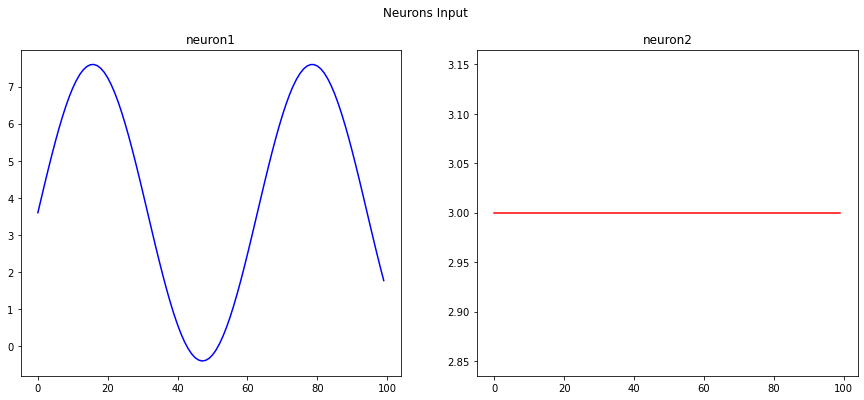

In [9]:
I1 = lambda x: 4 * (math.sin(x/10) + 0.9)
I2 = lambda x: 3
neuron1 = LIF(i_func=I1)
neuron2 = LIF(i_func=I2)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(15, 6)
fig.suptitle('Neurons Input')
ax1.plot(range(100), list(map(I1, range(100))), 'b')
ax1.set_title('neuron1')
ax2.plot(range(100), list(map(I2, range(100))), 'r')
ax2.set_title('neuron2')

In [10]:
neurons = [neuron1, neuron2]
connections = [[1], [0]]
neurons_group = NeuronsGroup(neurons, connections)
neurons_group.start()

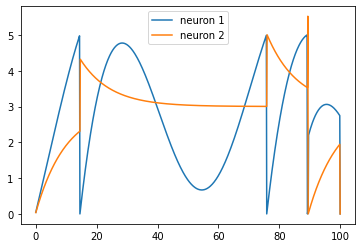

In [11]:
neurons_group.neurons_u_plot()

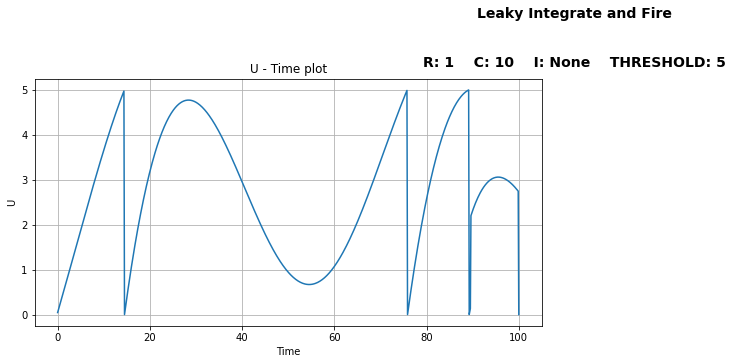

In [12]:
neuron1.draw_plot()

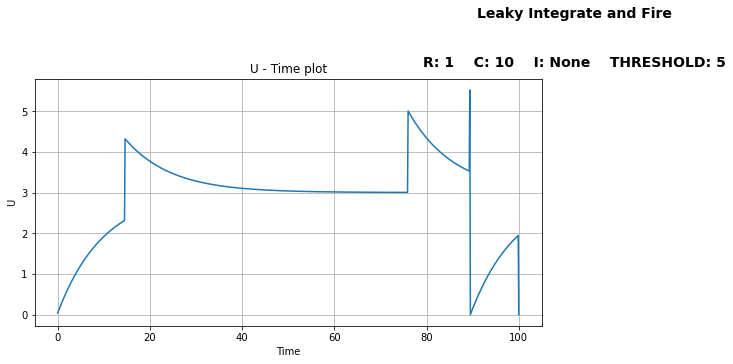

In [13]:
neuron2.draw_plot()

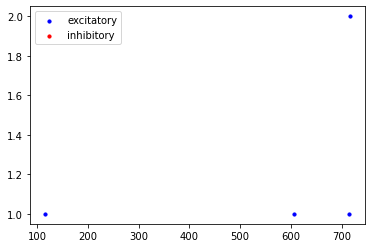

In [14]:
neurons_group.raster_plot()

# Test : 2

In [15]:
I = lambda x: 3

neuron1 = LIF(i_func=I, threshold=2.5)
neuron2 = LIF(i_func=I)
neuron3 = LIF(i_func=I)
neuron4 = LIF(i_func=I, neuron_type='inhibitory')

In [16]:


neurons = [neuron1, neuron2, neuron3, neuron4]
connections = [[1, 2, 3], [0, 2, 3], [0, 1, 3], [0, 1, 2]]
neurons_group = NeuronsGroup(neurons, connections, inhibitory_w=-1, excitatory_delay=3, inhibitory_delay=5)
neurons_group.start()



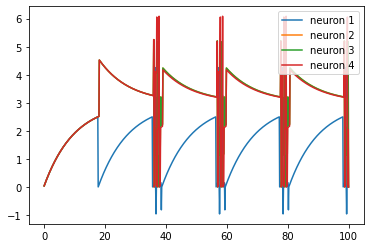

In [17]:
neurons_group.neurons_u_plot()

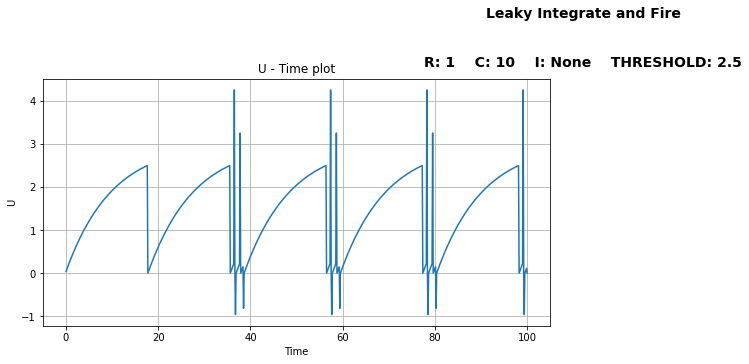

In [18]:
neuron1.draw_plot()

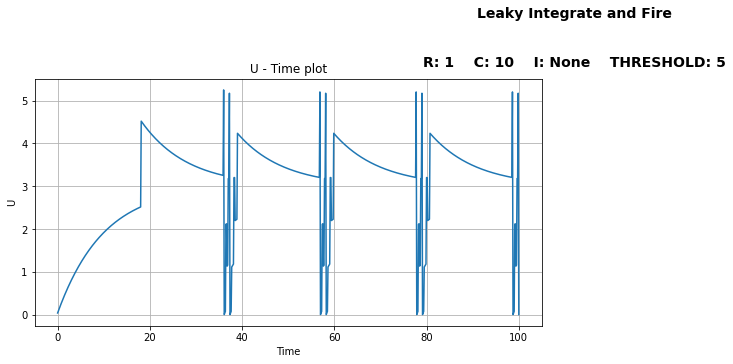

In [19]:
neuron2.draw_plot()

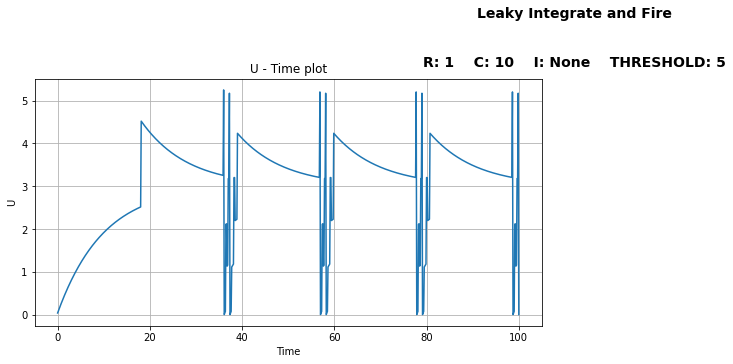

In [20]:
neuron3.draw_plot()

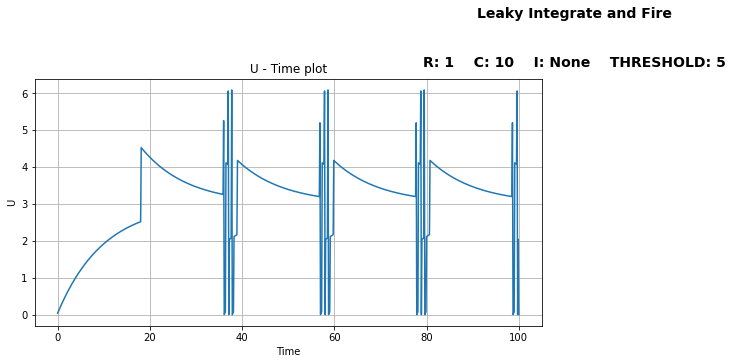

In [21]:
neuron4.draw_plot()

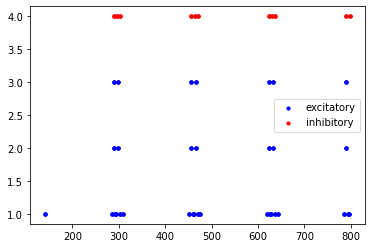

In [22]:


neurons_group.raster_plot()



# Test : 3

Text(0.5, 1.0, 'neuron4: Inhibitory')

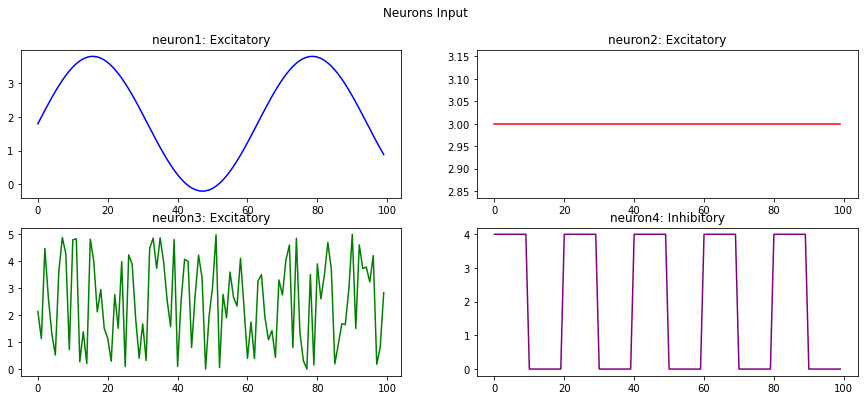

In [23]:
I1 = lambda x: 2 * (math.sin(x/10) + 0.9)
I2 = lambda x: 3
I3 = lambda x: random.random() * 5

def I4(x):
  if int(x/10)%2 == 0:
    return 4
  return 0

neuron1 = LIF(i_func=I1, threshold=2)
neuron2 = LIF(i_func=I2)
neuron3 = LIF(i_func=I3, threshold=3)
neuron4= LIF(i_func=I4, neuron_type='inhibitory')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_size_inches(15, 6)
fig.suptitle('Neurons Input')
ax1.plot(range(100), list(map(I1, range(100))), 'b')
ax1.set_title('neuron1: Excitatory')
ax2.plot(range(100), list(map(I2, range(100))), 'r')
ax2.set_title('neuron2: Excitatory')
ax3.plot(range(100), list(map(I3, range(100))), 'green')
ax3.set_title('neuron3: Excitatory')
ax4.plot(range(100), list(map(I4, range(100))), 'purple')
ax4.set_title('neuron4: Inhibitory')

In [24]:


neurons = [neuron1, neuron2, neuron3, neuron4]
connections = [[1, 2, 3], [0, 2, 3], [0, 1, 3], [0, 1, 2]]
neurons_group = NeuronsGroup(neurons, connections, excitatory_w=2, inhibitory_w=-2, excitatory_delay=4, inhibitory_delay=4)
neurons_group.start()



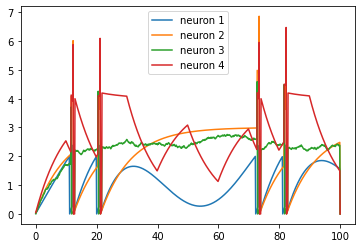

In [25]:


neurons_group.neurons_u_plot()



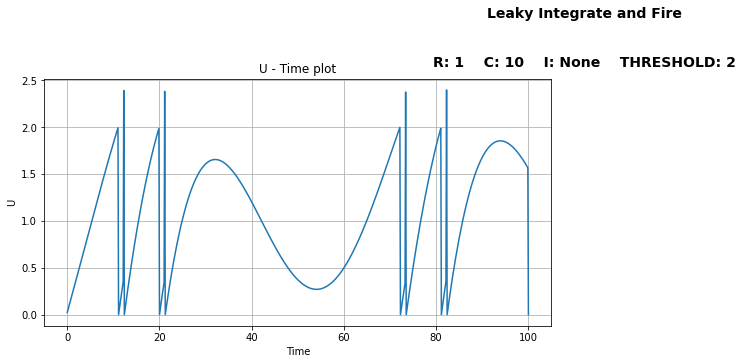

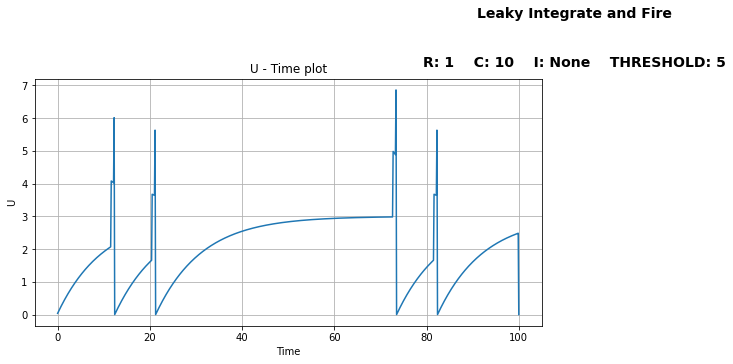

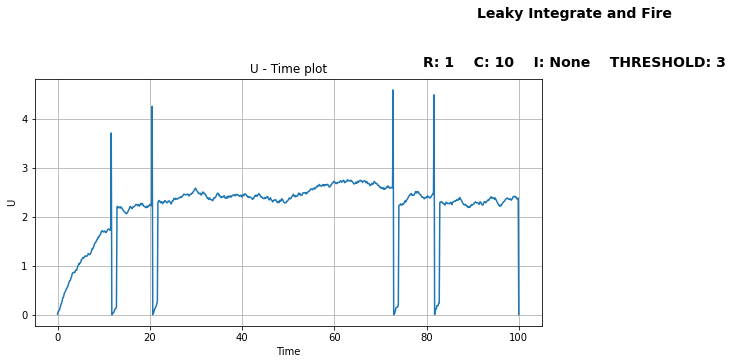

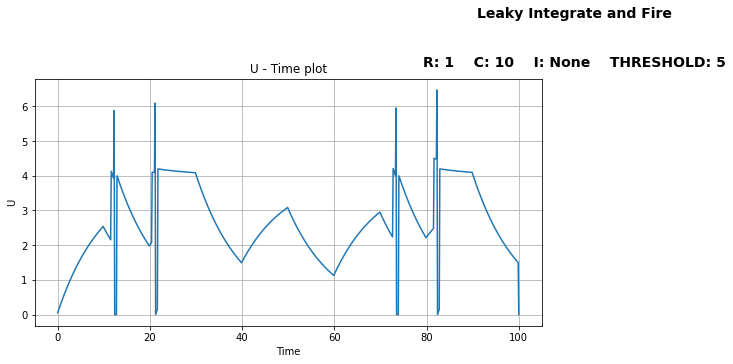

In [26]:
neuron1.draw_plot()
neuron2.draw_plot()
neuron3.draw_plot()
neuron4.draw_plot()

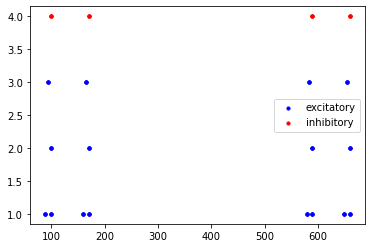

In [27]:
neurons_group.raster_plot()

# Create Neurons Group

In [28]:
def create_neuron_group(neurons_count, excitatory_count, inhibitory_count, excitatory_prob, inhibitory_prob, I, **kwargs):
  neurons = []
  connections = []
  excitatory_neuron_conn_count = math.ceil(neurons_count * excitatory_prob)
  inhibitory_neuron_conn_count = math.ceil(neurons_count * inhibitory_prob)

  for i in range(excitatory_count):
    args = {}
    if 'excitatory' in kwargs.keys():
      for arg in kwargs['excitatory']:
        args[arg] = kwargs[arg][i]
    neuron = LIF(I[i], neuron_type='excitatory', **args)
    neurons.append(neuron)
    connections.append(random.sample(range(neurons_count), excitatory_neuron_conn_count))
  for i in range(inhibitory_count):
    args = {}
    if 'Inhibitory' in kwargs.keys():
      for arg in kwargs['inhibitory']:
        args[arg] = kwargs[arg][i]
    neuron = LIF(I[i], neuron_type='inhibitory', **args)
    neurons.append(neuron)
    connections.append(random.sample(range(neurons_count), inhibitory_neuron_conn_count))
  
  neurons_group = NeuronsGroup(neurons, connections, **kwargs)
  return neurons_group

Text(0.5, 1.0, 'Input current')

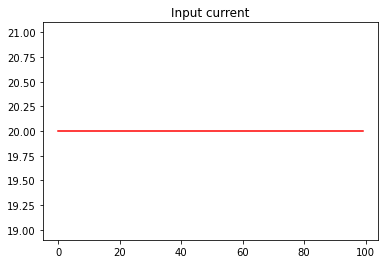

In [29]:
Is = []
for i in range(100):
  I = lambda x: 20
  Is.append(I)


plt.plot(range(100), list(map(Is[0], range(100))), 'r')
plt.title('Input current')

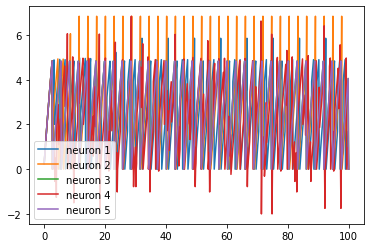

In [30]:


ng = create_neuron_group(100, 80, 20, 0.01, 0.02, Is)

ng.start()
ng.neurons_u_plot()



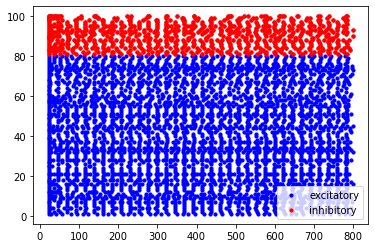

In [31]:
ng.raster_plot()

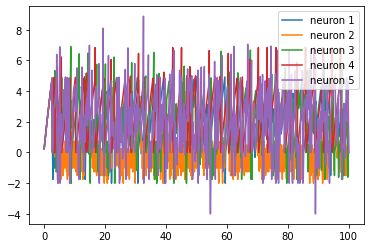

In [32]:
ng = create_neuron_group(100, 80, 20, 0.03, 0.03, Is)

ng.start()
ng.neurons_u_plot()

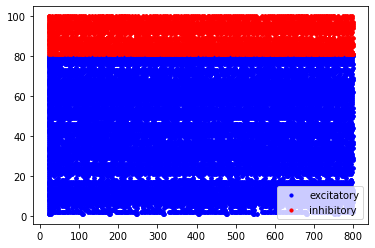

In [33]:
ng.raster_plot()

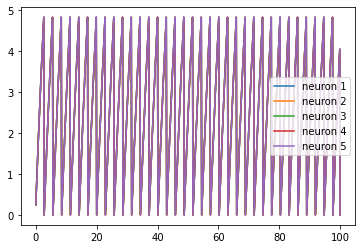

In [34]:
ng = create_neuron_group(100, 80, 20, 0.005, 0.004, Is)

ng.start()
ng.neurons_u_plot()

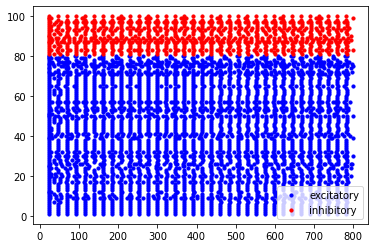

In [35]:
ng.raster_plot()

Text(0.5, 1.0, 'Input current')

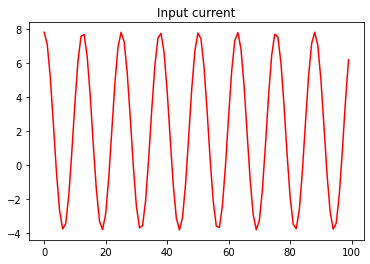

In [36]:


Is = []
for i in range(100):
  I = lambda x: 5.8 * math.cos(x/2) + 2
  Is.append(I)


plt.plot(range(100), list(map(Is[0], range(100))), 'r')
plt.title('Input current')



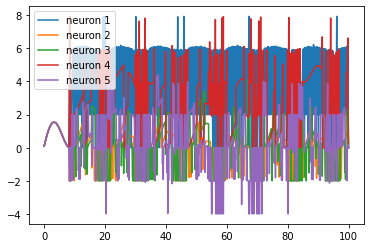

In [37]:


ng = create_neuron_group(100, 80, 20, 0.02, 0.03, Is)

ng.start()
ng.neurons_u_plot()



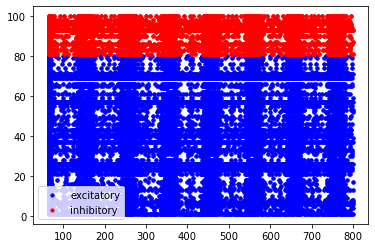

In [38]:


ng.raster_plot()



Text(0.5, 1.0, 'Input current')

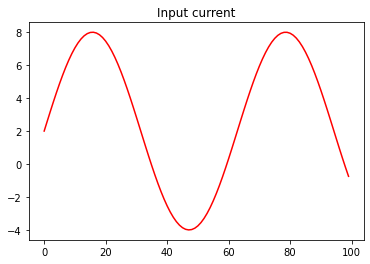

In [39]:


Is = []
for i in range(100):
  I = lambda x: 6 * math.sin(x/10) + 2
  Is.append(I)


plt.plot(range(100), list(map(Is[0], range(100))), 'r')
plt.title('Input current')



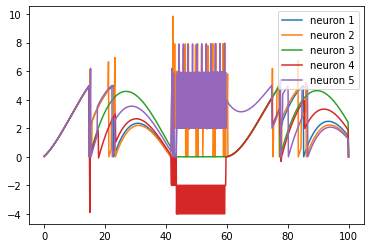

In [40]:
ng = create_neuron_group(100, 80, 20, 0.001, 0.001, Is)

ng.start()
ng.neurons_u_plot()

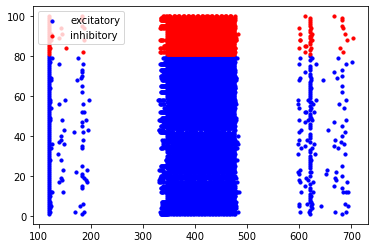

In [41]:
ng.raster_plot()

Text(0.5, 1.0, 'Input current')

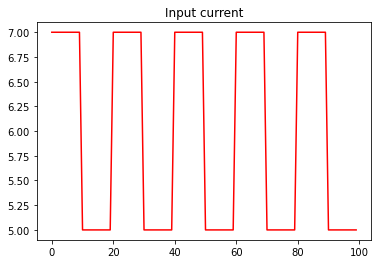

In [42]:
def I(x):
  if (x // 10) % 2 == 0:
    return 7
  return 5
Is = []
for i in range(100):
  Is.append(I)

plt.plot(range(100), list(map(Is[0], range(100))), 'r')
plt.title('Input current')

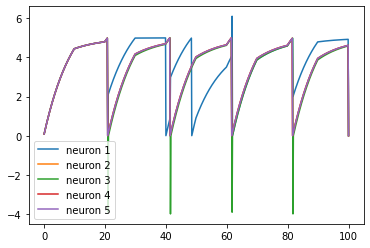

In [43]:


ng = create_neuron_group(100, 80, 20, 0.005, 0.004, Is)

ng.start()
ng.neurons_u_plot()



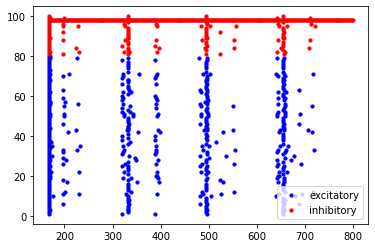

In [44]:


ng.raster_plot()



Text(0.5, 1.0, 'Input current')

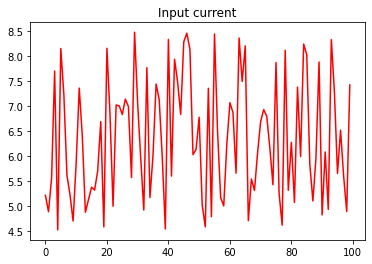

In [45]:


Is = []
for i in range(100):
  I = lambda x: random.random() * 4 + 4.5
  Is.append(I)


plt.plot(range(100), list(map(Is[0], range(100))), 'r')

plt.title('Input current')



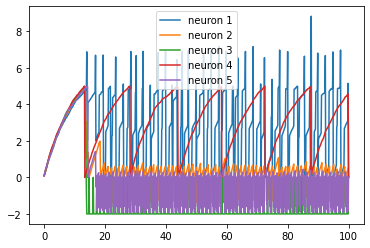

In [46]:


ng = create_neuron_group(100, 80, 20, 0.005, 0.05, Is)

ng.start()
ng.neurons_u_plot()



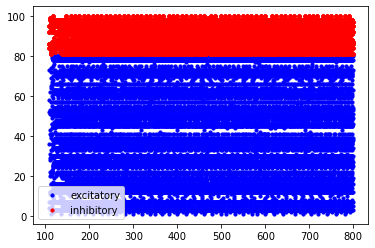

In [47]:
ng.raster_plot()

In [48]:
I1 = lambda x: 6
I2 = lambda x: 4
Is = []
for i in range(100):
  if i % 2 == 0:
    Is.append(I1)
  else:
    Is.append(I2)

Text(0.5, 1.0, 'Input current - 1')

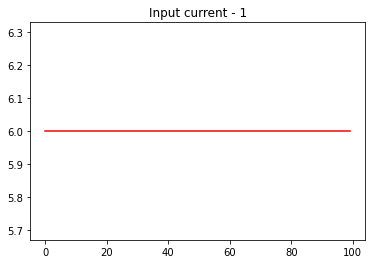

In [49]:
plt.plot(range(100), list(map(Is[0], range(100))), 'r')

plt.title('Input current - 1')

Text(0.5, 1.0, 'Input current - 2')

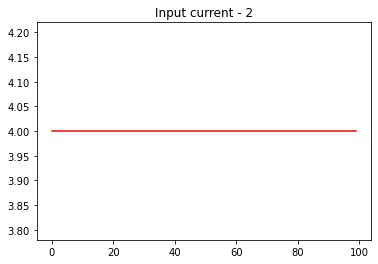

In [50]:


plt.plot(range(100), list(map(Is[1], range(100))), 'r')

plt.title('Input current - 2')



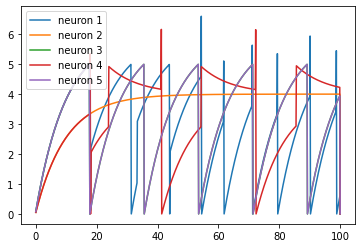

In [51]:


ng = create_neuron_group(100, 80, 20, 0.005, 0.02, Is)

ng.start()
ng.neurons_u_plot()



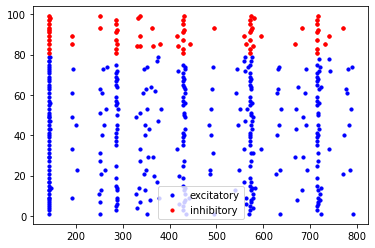

In [52]:
ng.raster_plot()

In [53]:
class NeuronsGroup:

  def __init__(self, neurons, connections, excitatory_w=2, inhibitory_w=-2, excitatory_delay=1,
               spikes_threshold = 20, connected_neuron_groups_effect = 2, inhibitory_delay=1, iteration_count=800):
    self.neurons = neurons
    self.neroun_action = []
    for i in neurons:
      self.neroun_action.append(i.start())

    self.connections = connections
    self.excitatory_w = excitatory_w
    self.inhibitory_w = inhibitory_w
    self.iteration_count = iteration_count
    self.spikes = []
    self.excitatory_spikes_time = []
    self.excitatory_spikes = []
    self.inhibitory_spikes_time = []
    self.inhibitory_spikes = []
    self.excitatory_delay = excitatory_delay
    self.inhibitory_delay = inhibitory_delay
    self.spikes_effect = []
    self.connected_neuron_groups = []
    self.spikes_threshold = spikes_threshold
    self.connected_neuron_groups_effect = connected_neuron_groups_effect
    
    
  def start(self):
    self.spikes_effect = [[0] * len(self.neurons) for _ in range(self.iteration_count)]
    for t in range(self.iteration_count):
    
      for i in range(len(self.neroun_action)):

        action_info = next(self.neroun_action[i])
        if action_info == True :
          
          for j in self.connections[i]:
            if self.neurons[i].type == 'excitatory':
              self.excitatory_spikes.append(i + 1)
              self.excitatory_spikes_time.append(t)
              if t+self.excitatory_delay < self.iteration_count:
                self.spikes_effect[t + self.excitatory_delay][j] += self.excitatory_w

            if self.neurons[i].type == 'inhibitory':
              self.inhibitory_spikes.append(i + 1)
              self.inhibitory_spikes_time.append(t)
              if t+self.inhibitory_delay < self.iteration_count:
                self.spikes_effect[t+self.inhibitory_delay][j] += self.inhibitory_w
      for i in range(len(self.neurons)):
        self.neurons[i].u[self.neurons[i].cur_time] += self.spikes_effect[t][i]
      yield

    
  def connect(self, neuron_group):
    self.connected_neuron_groups.append(neuron_group)
    
    
  def neurons_u_plot(self, neurons_count=5):
    legend = []
    for i in range(min(neurons_count, len(self.neurons))):
      plt.plot(list(map(lambda j: j * self.neurons[i].dt, range(len(self.neurons[i].u)))), self.neurons[i].u)
      legend.append('neuron ' + str(i+1))
    plt.legend(legend)

  def raster_plot(self):
    plt.scatter(self.excitatory_spikes_time, self.excitatory_spikes, color='blue', s=10)
    plt.scatter(self.inhibitory_spikes_time, self.inhibitory_spikes, color='red', s=10)
    plt.legend(['excitatory', 'inhibitory'])

In [54]:
def create_neuron_group(neurons_count, excitatory_count, inhibitory_count, excitatory_prob, inhibitory_prob, I, **kwargs):
  neurons = []
  connections = []
  excitatory_neuron_conn_count = math.ceil(neurons_count * excitatory_prob)
  inhibitory_neuron_conn_count = math.ceil(neurons_count * inhibitory_prob)

  for i in range(excitatory_count):
    args = {}
    if 'excitatory' in kwargs.keys():
      for arg in kwargs['excitatory']:
        args[arg] = kwargs[arg][i]
    neuron = LIF(I[i], neuron_type='excitatory', **args)
    neurons.append(neuron)
    connections.append(random.sample(range(neurons_count), excitatory_neuron_conn_count))
  for i in range(inhibitory_count):
    args = {}
    if 'Inhibitory' in kwargs.keys():
      for arg in kwargs['inhibitory']:
        args[arg] = kwargs[arg][i]
    neuron = LIF(I[i], neuron_type='inhibitory', **args)
    neurons.append(neuron)
    connections.append(random.sample(range(neurons_count), inhibitory_neuron_conn_count))
  
  neurons_group = NeuronsGroup(neurons, connections, **kwargs)
  return neurons_group

# Neurons Group Connectivity

In [55]:
exc_I_1 = []
for i in range(100):
  I = lambda x: 6
  exc_I_1.append(I)


neuron_group1 = create_neuron_group(100, 100, 0, 0.01, 0, exc_I_1)

In [56]:


exc_I_2 = []
for i in range(100):
  I = lambda x: 7
  exc_I_2.append(I)


neuron_group2 = create_neuron_group(100, 100, 0, 0.01, 0, exc_I_2)



In [57]:
inh_I = []
for i in range(100):
  I = lambda x: 5.5
  inh_I.append(I)


neuron_group3 = create_neuron_group(100, 0, 100, 0, 0.1, inh_I)

In [58]:
neuron_group1.connect(neuron_group3)
neuron_group2.connect(neuron_group3)

In [59]:
ng1 = neuron_group1.start()
ng2 = neuron_group2.start()
ng3 = neuron_group3.start()

for i in range(neuron_group1.iteration_count):
  next(ng1)
  next(ng2)
  next(ng3)

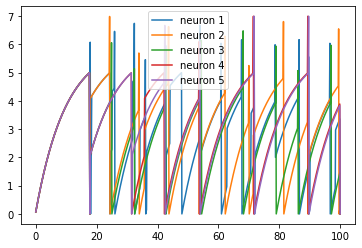

In [60]:
neuron_group1.neurons_u_plot()

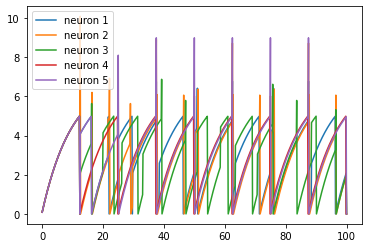

In [61]:
neuron_group2.neurons_u_plot()

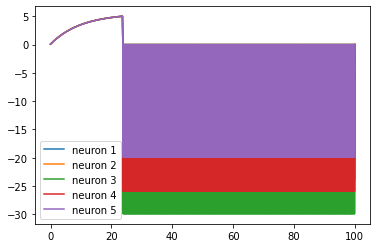

In [62]:


neuron_group3.neurons_u_plot()



Text(0.5, 1.0, 'Input current')

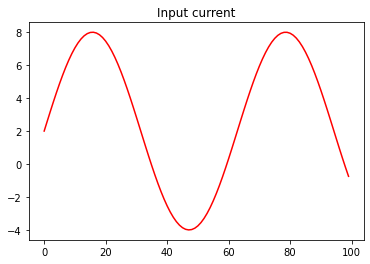

In [63]:
exc_I_1 = []
for i in range(100):
  I = lambda x: 6 * math.sin(x/10) + 2
  exc_I_1.append(I)


neuron_group1 = create_neuron_group(100, 100, 0, 0.01, 0, exc_I_1)
plt.plot(range(100), list(map(exc_I_1[0], range(100))), 'r')
plt.title('Input current')

Text(0.5, 1.0, 'Input current')

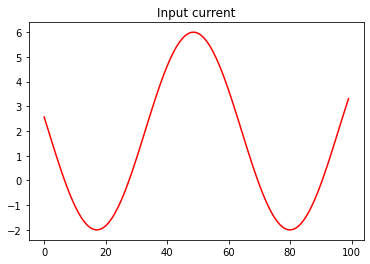

In [64]:


exc_I_2 = []
for i in range(100):
  I = lambda x: 4 * math.sin((x + 30)/10) + 2
  exc_I_2.append(I)


neuron_group2 = create_neuron_group(100, 100, 0, 0.01, 0, exc_I_2)
plt.plot(range(100), list(map(exc_I_2[0], range(100))), 'r')
plt.title('Input current')



Text(0.5, 1.0, 'Input current')

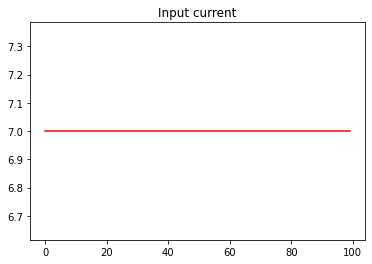

In [65]:
inh_I = []
for i in range(100):
  I = lambda x: 7
  inh_I.append(I)


neuron_group3 = create_neuron_group(100, 0, 100, 0, 0.1, inh_I)
plt.plot(range(100), list(map(inh_I[0], range(100))), 'r')
plt.title('Input current')

In [66]:
neuron_group1.connect(neuron_group3)
neuron_group2.connect(neuron_group3)

In [67]:
ng1 = neuron_group1.start()
ng2 = neuron_group2.start()
ng3 = neuron_group3.start()

for i in range(neuron_group1.iteration_count):
  next(ng1)
  next(ng2)
  next(ng3)

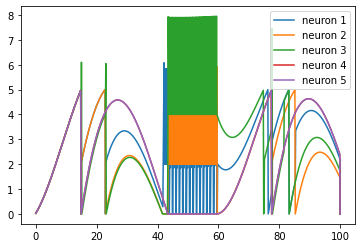

In [68]:


neuron_group1.neurons_u_plot()



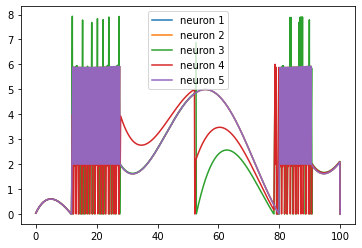

In [69]:
neuron_group2.neurons_u_plot()


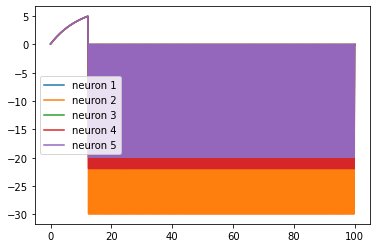

In [70]:

neuron_group3.neurons_u_plot()